In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../"))

from desc import set_device
set_device("gpu")

In [38]:
import numpy as np
np.set_printoptions(linewidth=np.inf, suppress=False, threshold=sys.maxsize)
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.constants import mu_0
import plotly.graph_objects as go
import warnings

from desc.backend import jnp
from desc.transform import Transform
from desc.plotting import plot_1d,plot_3d,plot_comparison, plot_surfaces, plot_grid
from desc.optimize import Optimizer
from desc.examples import get
from desc.objectives import get_fixed_boundary_constraints, maybe_add_self_consistency
from desc.grid import LinearGrid, QuadratureGrid, Grid

from desc.compute.utils import _compute as compute_fun
from desc.nestor import Nestor
from desc.objectives.objective_funs import _Objective
from desc.singularities import (
    DFTInterpolator,
    FFTInterpolator,
    virtual_casing_biot_savart,
    _nonsingular_part,
    _singular_part,
    kernels,
)
from desc.utils import Timer, errorif, warnif

from desc.objectives import (
    ObjectiveFunction, 
    BFieldErrorAtIslandSurface, 
    ForceBalance,
    FixBoundaryR,
    FixBoundaryZ,
    FixPsi,
    FixPressure,
    FixCurrent,
    Volume,
    AspectRatio,
)

Precomputing transforms
Building objective: |B| Error at the Island Surface
Precomputing transforms
Timer: Precomputing transforms = 60.5 ms
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 34.7 ms
Timer: Objective build = 257 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 63.6 ms
Timer: Objective build = 217 ms
Timer: Proximal projection build = 2.44 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Timer: Objective build = 944 ms
Timer: Linear constraint projection build = 1.16 sec
Number of parameters: 80
Number of objectives: 1090
Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          8.038e+00                                    6.902e+02   
       1              2          3.

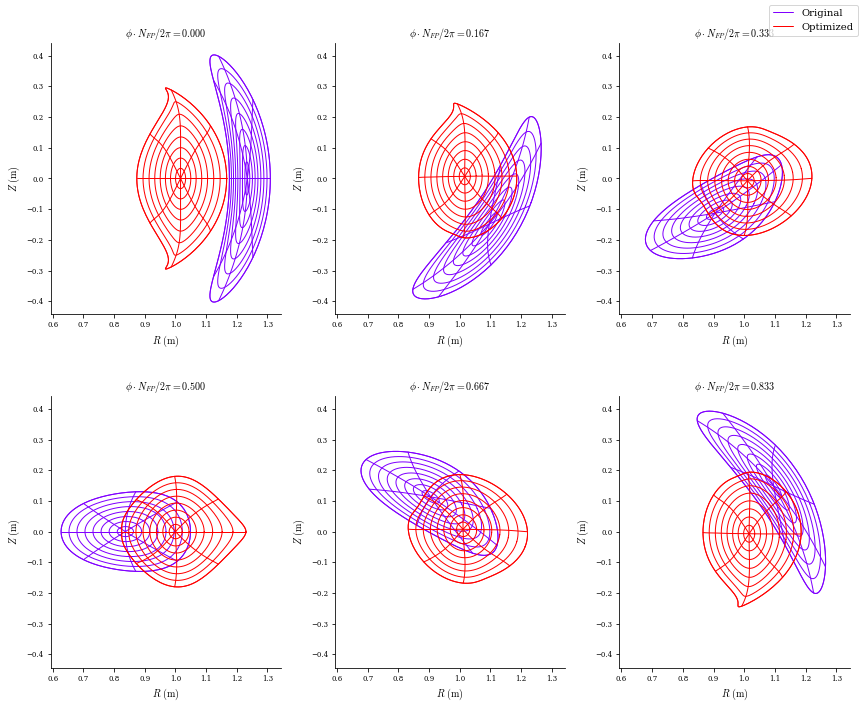

In [48]:
fix_modes = 4
island_rho = 0.5

eq = get("precise_QA")
eq_org = eq.copy()

AR = eq.compute("R0/a")["R0/a"]
ARbounds = (0.95 * AR, 1.05 * AR)

V = eq.compute("V")["V"]
Vbounds = (0.95 * V, 1.05 * V)
    
optimizer = Optimizer("proximal-lsq-exact")
# fix |m| <= "fix_modes" modes

R_modes = np.vstack(
        (
            [0, 0, 0],
            eq.surface.R_basis.modes[
                np.max(np.abs(eq.surface.R_basis.modes), 1) > fix_modes, :
            ],
        )
    )
Z_modes = eq.surface.Z_basis.modes[
    np.max(np.abs(eq.surface.Z_basis.modes), 1) > fix_modes, :
]
constraints = (
    FixBoundaryR(eq=eq, modes=R_modes),
    FixBoundaryZ(eq=eq, modes=Z_modes),
    ForceBalance(eq=eq),
    FixPressure(eq=eq),
    FixCurrent(eq=eq),
    FixPsi(eq=eq),
)
objective = ObjectiveFunction(
    (
        BFieldErrorAtIslandSurface(eq=eq, rho=island_rho), 
        AspectRatio(eq=eq, bounds=ARbounds),
    )
)
Berror = BFieldErrorAtIslandSurface(eq=eq, rho=island_rho)
Berror.build()
cost = Berror.compute(*Berror.xs(eq))

eq.optimize(
    optimizer=optimizer,
    constraints=constraints,
    objective=objective,
    verbose=3,
    maxiter=100,
    options={
        # sometimes the default initial trust radius is too big, allowing the
        # optimizer to take too large a step in a bad direction. If this happens,
        # we can manually specify a smaller starting radius.
        "initial_trust_radius": 0.5,
    },
)

plot_comparison(eqs=[eq_org, eq], labels=["Original", "Optimized"]);
# plt.savefig("test-precise-QA.png", dpi=500)

In [47]:
grid = LinearGrid(rho=island_rho, M=eq.M, N=eq.N, NFP=int(eq.NFP))
Batr = eq.compute("|B|",grid=grid)["|B|"]
Batr = Batr[:, None]
Batr
# cost = np.array(cost)
# cost = cost[:, None]
# cost

Array([[0.98741022],
       [0.9916256 ],
       [1.00337801],
       [1.02025842],
       [1.03911557],
       [1.05697419],
       [1.07163704],
       [1.08182994],
       [1.08700591],
       [1.08700591],
       [1.08182994],
       [1.07163704],
       [1.05697419],
       [1.03911557],
       [1.02025842],
       [1.00337801],
       [0.9916256 ],
       [0.98741994],
       [0.99226816],
       [1.00474777],
       [1.02233627],
       [1.04168887],
       [1.05967303],
       [1.07401171],
       [1.08342737],
       [1.08747443],
       [1.086213  ],
       [1.07990983],
       [1.06897354],
       [1.05409979],
       [1.03653459],
       [1.01829986],
       [1.00214138],
       [0.99104683],
       [0.98742412],
       [0.99267077],
       [1.00564485],
       [1.0236993 ],
       [1.04334681],
       [1.0613862 ],
       [1.0755113 ],
       [1.08440526],
       [1.08762366],
       [1.08536655],
       [1.07817012],
       [1.06670608],
       [1.05180234],
       [1.034

Setting parameters took: 4.20 seconds


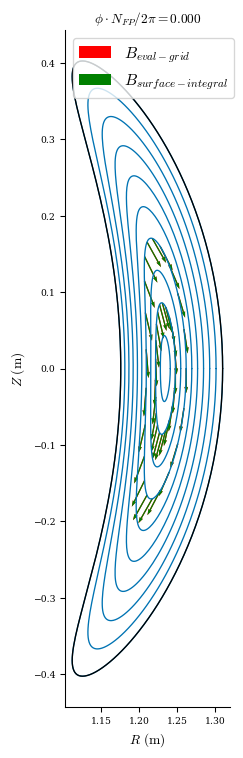

In [5]:
from desc.magnetic_fields._core import B_from_surface_integral
import time

eq = get("precise_QA")

t0 = time.time()
grid_source = LinearGrid(rho=1, M=550, N=550, NFP=int(eq.NFP))
grid_eval = LinearGrid(rho=np.array([0.2, 0.4]), M=10, N=0, NFP=int(eq.NFP))

keys = [
    "K_vc",
    "|e_theta x e_zeta|",
    "R",
    "phi",
    "Z",
    "e^rho",
    "e^theta",
]
data_source = eq.compute(keys, grid=grid_source)
data_eval = eq.compute(keys, grid=grid_eval)

re = jnp.vstack((data_eval["R"], data_eval["phi"], data_eval["Z"])).T
rs = jnp.vstack((data_source["R"], data_source["phi"], data_source["Z"])).T
dA = grid_source.weights * data_source["|e_theta x e_zeta|"] / grid_source.NFP
K = data_source["K_vc"]
print(f"Setting parameters took: {time.time()-t0:.2f} seconds")

Bplasma2 = B_from_surface_integral(re, rs, K, eq.NFP, dA)  
scale = 2
fig,ax = plot_surfaces(eq,theta=0,rho=np.arange(0.1,1.01,0.1), phi=0.0,figsize=(8,8),lcfs_color="k")
ax[0].quiver(data_eval["R"],data_eval["Z"],data_eval["B"][:,0],data_eval["B"][:,2],
             label=r"$B_{eval-grid}$",scale=scale,color="r")
ax[0].quiver(data_eval["R"],data_eval["Z"],Bplasma2[:,0],Bplasma2[:,2],
             label=r"$B_{surface-integral}$",scale=scale,color="g")
ax[0].legend(fontsize=12)
fig=plt.gcf()
plt.savefig("test-precise-QA-B.png", dpi=500)

In [ ]:
from desc.magnetic_fields import field_line_integrate, ToroidalMagneticField
from desc.magnetic_fields._core import biot_savart_general
from desc.compute import rpz2xyz, rpz2xyz_vec, xyz2rpz_vec
from desc.backend import jnp, fori_loop

def B_from_K_trace(re, params=None, basis="rpz",source_grid=grid_source):
    phi_re = re[:, 1]
    re = rpz2xyz(re)
    def nfp_loop(j, f):
        # calculate (by rotating) rs, rs_t, rz_t
        phi = (grid_source.nodes[:, 2] + j * 2 * jnp.pi / grid_source.NFP) % (
            2 * jnp.pi
        )
        # new coords are just old R,Z at a new phi (bc of discrete NFP symmetry)
        rs = jnp.vstack((_rs[:, 0], phi, _rs[:, 2])).T
        rs = rpz2xyz(rs)
        
        K = rpz2xyz_vec(_K, phi=phi)
        fj = biot_savart_general(
            re,
            rs,
            K,
            _dV,
        )
        f += fj
        return f

    Bplasma = fori_loop(0, grid_source.NFP, nfp_loop, jnp.zeros_like(re))
    Bplasma = xyz2rpz_vec(Bplasma, phi=phi_re)
    return Bplasma

grid_source = LinearGrid(rho=1, M=550, N=550, NFP=int(eq.NFP))

keys = [
    "K_vc",
    "|e_theta x e_zeta|",
    "R",
    "phi",
    "Z",
]
data_source = eq.compute(keys, grid=grid_source)
_rs = jnp.vstack((data_source["R"], data_source["phi"], data_source["Z"])).T
_dV = grid_source.weights * data_source["|e_theta x e_zeta|"] / grid_source.NFP
_K = data_source["K_vc"]

ntransit=50
n_R_points = 10

phis = np.arange(0, ntransit * 2 * np.pi, 2 * np.pi)
rrr = np.linspace(1.17,1.25,n_R_points) # initial R positions of field-lines to trace
Bfield = ToroidalMagneticField(1,1)
Bfield.compute_magnetic_field = B_from_K_trace
field_R, field_Z = field_line_integrate(rrr, np.zeros_like(rrr), phis, Bfield, source_grid=grid_source)